In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from scipy import stats
import itertools as it
import sklearn.metrics as metrics
import sklearn.model_selection as selection
import os
import json
import pickle as pic
import importlib

import sys
sys.path.append("./../utils")
sys.path.append("./../sklearn")
import plot
import util
import constants as const
import ColumnTransformer
importlib.reload(util)
importlib.reload(const)
importlib.reload(ColumnTransformer)
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)
pd.set_option('precision', 6)

# 1. Load data

In [2]:
# Real-world graphs, R-MAT and Albert Barabsi
combined_graphs_encoded = pd.read_csv("../data/combined.csv")
# Wiki graphs for enrichment
graphs_for_enrichment = pd.read_csv("../data/enrichment.csv")
# The used partitioners
partitioners = list(combined_graphs_encoded.partitioner.unique())


In [3]:
combined_graphs_encoded.to_csv("~/cephstorage/testfile.csv")

# 2. Overview datasets
The datasets consists of real-world and synthetically generated graphs (rmat and Albert Barabasi graphs)

In [4]:
all_rmat_graphs = combined_graphs_encoded[combined_graphs_encoded.graph_type.str.startswith("rmat-")]
all_realworld_graphs = combined_graphs_encoded[combined_graphs_encoded.graph_type.str.startswith("realworld-")]
all_barabasi_graphs= combined_graphs_encoded[combined_graphs_encoded.graph_type.str.startswith("barabasi")]

unique_graphs  = combined_graphs_encoded.groupby(["graph"],as_index=False).first() 
graphs_rmat = unique_graphs[unique_graphs.graph_type.str.startswith("rmat-")]
graphs_realworld = unique_graphs[(unique_graphs.graph_type.str.startswith("realworld-"))&(unique_graphs.graph_type.isin(['realworld-affiliation', 'realworld-citation','realworld-collaboration', 'realworld-interaction', 'realworld-internet','realworld-product_network', 'realworld-soc','realworld-web' ,'realworld-wiki']))]
graphs_barabsi = unique_graphs[unique_graphs.graph_type.str.startswith("barabasi")]

# 2.1 Number of graphs
We create 6\*11=66 samples out of each graph, since we used 5 partition sizes and 11 partitioners. 

In [5]:
graph2typecount = graphs_realworld.groupby(["graph_type"], as_index=False).count()[["graph_type", "num_vertices"]]
graph2typecount = graph2typecount.rename(columns={"num_vertices": "#graphs"})
print("Total Test Set (only realworld graphs):", graph2typecount["#graphs"].sum())
print("Total Graphs for Enrchrichment (real-world wiki graphs):", len(graphs_for_enrichment.graph.unique()))
print("Total R-MAT Graphs :", len(graphs_rmat.graph.unique()))
print("Total Barabasi Graphs :", len(graphs_barabsi))
graph2typecount

Total Test Set (only realworld graphs): 80
Total Graphs for Enrchrichment (real-world wiki graphs): 96
Total R-MAT Graphs : 297
Total Barabasi Graphs : 69


,graph_type,#graphs
0,realworld-affiliation,12
1,realworld-citation,3
2,realworld-collaboration,6
3,realworld-interaction,5
4,realworld-internet,5
5,realworld-product_network,1
6,realworld-soc,31
7,realworld-web,12
8,realworld-wiki,5


## 2.2 Graph Property Coverage
How well do the synthetic generated graphs cover the properties of the realworld graphs?

9
9
9
9
9
8


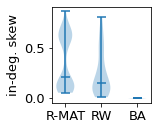

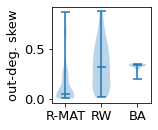

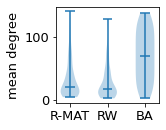

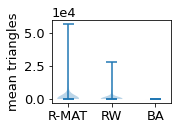

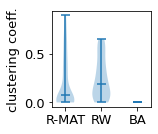

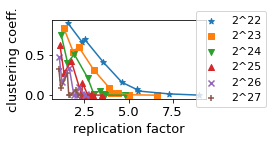

In [6]:
features = [
    'pearson_mode_degrees_in', 
    'pearson_mode_degrees_out', 
    'mean_degree',
    'mean_triangles', 
    'average_lcc',
]
features_readable = [
    "in-deg. skew",
    "out-deg. skew", 
    "mean degree", 
    "mean triangles", 
    "clustering coeff."
]

plt.rcParams.update({'font.size': 13})

index = 0
for feature in features:
    plt.rcParams["figure.figsize"] = (2.5, 2)
    fig, ax = plt.subplots()
    _rmat = graphs_rmat[feature].to_numpy()
    _realworld = graphs_realworld[feature].to_numpy()
    _barabasi = graphs_barabsi[feature].to_numpy()

    ax.set_ylabel(features_readable[index])
    ax.violinplot([_rmat, _realworld, _barabasi],showmeans=False, showmedians=True, showextrema=True)
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    labels = ['R-MAT', 'Real-world', "barabsi"]
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(['R-MAT', 'RW', "BA"])
    
    if feature in features[3]:
   # if True:
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,2))
    
    fig.tight_layout() 
    plt.savefig("../figures/" + features[index]+".pdf")
    index += 1
    
    
plt.rcParams["figure.figsize"] = (4, 2)  
HDRF = all_rmat_graphs[
    (all_rmat_graphs.num_partitions == 64) & 
    (all_rmat_graphs.partitioner == "hdrf") & 
    (all_rmat_graphs.num_edges == 160000000)
]
HDRF["V"] = HDRF["graph"].str.split('-').str[2]
markers = ["*", "s", "v", "^", "x", "+",]
marker_index = -1
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (2.4, 2)

vs = []
for vv in list(HDRF.V.unique()):
    vs.append(int(vv))
vs.sort()

#print(vs)

for v in vs:
    d = HDRF[HDRF.V == str(v)]
    marker_index += 1 
    d = d.sort_values(by=["replication_factor", "V"])
    #exponent = "2$^{"+str(int(np.log2(int(v)))) + "}$"
    exponent = "2^"+str(int(np.log2(int(v)))) + ""
    ax.scatter(d["replication_factor"], d["average_lcc"],label=exponent, marker=markers[marker_index])
    print(len(d["average_lcc"]))
    ax.plot(d["replication_factor"], d["average_lcc"] )


ax.set_ylabel("clustering coeff.")
ax.set_xlabel("replication factor")
ax.legend(prop={'size': 8})
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=6, fancybox=True, shadow=True, prop={'size': 8})
ax.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), ncol=1, prop={'size': 11})
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout() 
plt.savefig("../figures/rep-vs-cc.pdf")

['1dd', '1ds', '2d', '2ps', 'crvc', 'dbh', 'hdrf', 'hep1', 'hep10', 'hep100', 'ne']


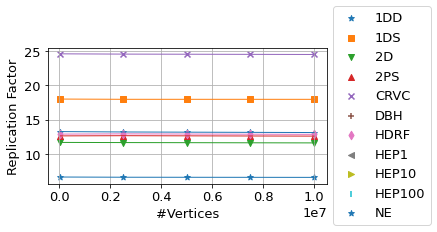

In [7]:
barabasi_fix_k_var_v = pd.read_csv("../data/barabasi-X-20.csv")
plt.rcParams["figure.figsize"] = (5, 2.5)
ps = list(all_barabasi_graphs.partitioner.unique())
ps.sort()
print(ps)
i = -1
markers = ["*", "s", "v", "^", "x", "+","d", "<", ">", "|"]
fig, ax = plt.subplots(1)
for partitioner in [k.upper() for k in ps]:
    i += 1
    l = barabasi_fix_k_var_v[(barabasi_fix_k_var_v.partitioner == partitioner) & (barabasi_fix_k_var_v.num_partitions == 64)]
    l = l.sort_values(by=["V"])
    plt.scatter(l["V"], l["replication_factor"], label=str(partitioner), marker=markers[i%10])
    plt.plot(l["V"], l["replication_factor"],linewidth=1.0)
plt.ylabel("Replication Factor")
plt.xlabel("#Vertices")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("../figures/barabasi-x-20.pdf",  borderaxespad=0, bbox_inches='tight')

# 3. Overview scores

In [8]:
results = pd.DataFrame(columns=["target", "model", "dataset", "features", "mape", "rmse", "spearman"])
target_description = [
    "vertex_balance", 
    "destination_balance", 
    "source_balance", 
    "edge_balance", 
    "replication_factor"
    ]
feature_description = [
    "Easy", 
    "Hard"
    ]
test_set = [
    "validation", 
    "test"
   ]
models = [
    "RFR", 
    "KNN", 
    "SVR", 
    "XGB",
    "PolyRegression",
    "MLP"
    ]

for td in target_description:
    for fd in feature_description:
        for ts in test_set:
            for model in models:
                if fd == "Hard" and not td == "replication_factor":
                    continue
                key = "{}_{}-{}_{}".format(model, fd, ts, td)
                _results =  pd.read_csv("../models/" + key)
                
                if ts == "test":
                    _results = _results[(_results.enriched_by==0.0) & (_results.level=="all") & (_results.partitioner=="all") ][["rmse", "mape","spearman"]]
                else:
                    _results = _results[(_results.enriched_by==0.0)  ][["rmse", "mape", "spearman"]]
                _results["target"] = [td]
                _results["features"] = [fd]
                _results["dataset"] = [ts]
                _results["model"] = [model]
                results = pd.concat([results, _results])
# Format for latex    
results['target'] = results['target'].replace({
    'vertex_balance':'$B_{v}(P)$',
    'destination_balance':'$B_{dst}(P)$',
    'source_balance':'$B_{src}(P)$',
    'edge_balance':'$B_{edge}(P)$',
    'replication_factor':'$RF(P)$',
})

results['features'] = results['features'].replace({
    'Easy':"basic",
    "Hard": "adv."
})
    
results['dataset'] = results['dataset'].replace({
    'validation':"val",
})        

results[["mape", "rmse"]] = results[["mape", "rmse"]].apply(pd.to_numeric).round(3)



In [9]:
results["model"].unique()

array(['RFR', 'KNN', 'SVR', 'XGB', 'PolyRegression', 'MLP'], dtype=object)

select models based on best crossvalidation score.

In [10]:
# .max() is correct, because if mape is used is score mape is multiplied by -1 to transform error to score metric
idx = results[results.dataset == "val"].groupby(["target", "features"])['mape'].transform(max) == results[results.dataset == "val"]['mape']
# Now, we report the mape for the best model selected in the line above.
best_scores_overall_df = results[results.dataset == "val"][idx]
best_models_based_on_cross_validation = best_scores_overall_df[["target", "model"]]
best_models_based_on_cross_validation["best"] = True # For the join later on
best_models_based_on_cross_validation

,target,model,best
0,$B_{v}(P)$,RFR,True
0,$B_{dst}(P)$,RFR,True
0,$B_{src}(P)$,RFR,True
0,$B_{edge}(P)$,RFR,True
0,$RF(P)$,XGB,True
0,$RF(P)$,XGB,True


# Final Scores (Table 6)

In [11]:
selected_models = pd.merge(results, best_models_based_on_cross_validation, on=["target", "model"])
selected_models[selected_models.dataset == "test"][["target", "model","features", "mape", "rmse"]]

,target,model,features,mape,rmse
1,$B_{v}(P)$,RFR,basic,0.152,0.921
3,$B_{dst}(P)$,RFR,basic,0.154,1.020
5,$B_{src}(P)$,RFR,basic,0.144,0.851
7,$B_{edge}(P)$,RFR,basic,0.079,1.055
10,$RF(P)$,XGB,basic,0.296,1.197
11,$RF(P)$,XGB,basic,0.296,1.197
14,$RF(P)$,XGB,adv.,0.288,1.238
15,$RF(P)$,XGB,adv.,0.288,1.238


# Enrichment

In [12]:

for model_name in  [
    "RFR", 
    ]:
    print("#"*100)    
    print("Model", model_name)
    print("#"*100)          
    target_description = [
        "replication_factor",
        "vertex_balance", 
        "destination_balance", 
        "source_balance", 
        "edge_balance", 
        ]
    feature_description = [
        "Easy", 
    ]
    test_set = [
        "test"
    ]

    result_enrichments_overview = []
    for td in target_description:
        for fd in feature_description:
            for ts in test_set:
                key = "{}_{}-{}_{}".format(model_name, fd, ts, td)
                data = pd.read_csv("../models/" + key)
                
                for g_type in ["all", "realworld-wiki"]:
                    no_enrichment = data[(data.enriched_by==0.0) & (data.level==g_type) & (data.partitioner=="all") ][["rmse", "mape", "r2","spearman"]].mean()
                    enrichment = data[(data.enriched_by==1.0) & (data.level==g_type) & (data.partitioner=="all") ][["rmse", "mape", "r2","spearman"]].mean()  

                    result_enrichments_overview.append({
                        "target": td,
                        "features": fd,
                        "mape": no_enrichment["mape"],
                        "mape_enriched": enrichment["mape"],
                        "spearman": no_enrichment["spearman"],
                        "spearman_enriched": enrichment["spearman"],
                        "graph_type": g_type,
                        "factor": enrichment["mape"] / no_enrichment["mape"],
                        "factor_inversed": no_enrichment["mape"] / enrichment["mape"],
                        "is_balance_metric": "balance" in td
                        

                    })
            
                
    ov = pd.DataFrame(result_enrichments_overview)
    print(ov)
    print(ov[(ov.is_balance_metric) & (ov.features == "Easy")].groupby(["graph_type"]).mean())
    rr = ov[(ov.is_balance_metric) & (ov.features == "Easy")].groupby(["graph_type"]).mean()
    rr

####################################################################################################
Model RFR
####################################################################################################
                target features      mape  mape_enriched  spearman  \
0   replication_factor     Easy  0.302958       0.253159  0.951207   
1   replication_factor     Easy  0.555234       0.243686  0.948636   
2       vertex_balance     Easy  0.152435       0.182764  0.872169   
3       vertex_balance     Easy  0.186825       0.142701  0.888131   
4  destination_balance     Easy  0.154365       0.161379  0.870290   
5  destination_balance     Easy  0.134479       0.111236  0.880455   
6       source_balance     Easy  0.143984       0.155242  0.880309   
7       source_balance     Easy  0.225267       0.152849  0.899545   
8         edge_balance     Easy  0.078961       0.116073  0.769235   
9         edge_balance     Easy  0.078389       0.048261  0.717245   

   spearman_enric

In [13]:
 rr

,mape,mape_enriched,spearman,spearman_enriched,factor,factor_inversed,is_balance_metric
graph_type,,,,,,,
all,0.132436,0.153864,0.848001,0.836806,1.198149,0.849585,True
realworld-wiki,0.156240,0.113762,0.846344,0.890034,0.721292,1.404054,True


Model: RFR for target replication_factor
MAPE wihout enrichment              level  mape_mean
54  realworld-wiki   0.555234
MAPE wih 20% enrichment              level  mape_mean
55  realworld-wiki   0.369815
MAPE with 100% enrichment              level  mape_mean
59  realworld-wiki   0.243686


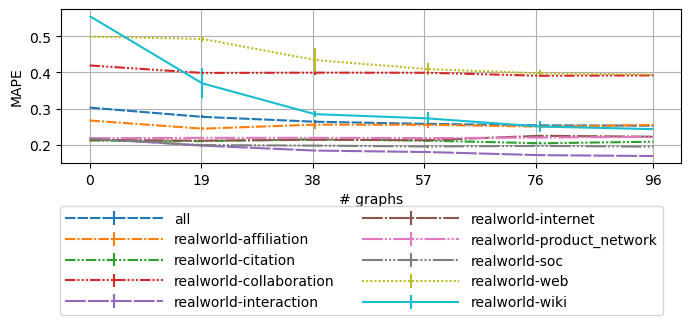

In [14]:
def plot_scores_by_enrichment_level(data, target):
    scores = data[(data.partitioner == "all")]
    raw = []

    for i,d in scores.groupby(["level", "enriched_by"], as_index=False):
        raw.append({
            "level": i[0],
            "enriched_by": i[1],
            "rmse_mean": np.mean(d["rmse"]), 
            "rmse_std": np.std(d["rmse"]),
            "r2_mean": np.mean(d["r2"]/100), 
            "r2_std": np.std(d["r2"]/100),
            "mape_mean": np.mean(d["mape"]), 
            "mape_std": np.std(d["mape"]),
            "spearman_mean": np.mean(d["spearman"]), 
            "spearman_std": np.std(d["spearman"]),
        })
    scores_by_enrichment = pd.DataFrame(raw)   
    #print(scores_by_enrichment)
    linestyle_tuple = [
        ('x', (0, (5,1))),
        ('x', (0, (5,1,1,1))),
        ('x', (0, (5,1,1,1,1,1))),
        ('x', (0, (5,1,1,1,1,1,1,1))),
        ('x', (0, (10,1))),
        ('x', (0, (10,1,1,1))),
        ('x', (0, (10,1,1,1,1,1))),
        ('x', (0, (10,1,1,1,1,1,1,1))),
        ('x', (0, (1, 1))),
        ('x', (0, (20, 0))),
    ]
    c = -1
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (8,2)
  #  plt.rcParams["figure.figsize"] = (14,30)
    plt.rcParams['font.size'] = 10

    fig, ax = plt.subplots(1, 1)
    
    scores_by_enrichment["enriched_by_abs"] = scores_by_enrichment["enriched_by"] * 96
    
    print("MAPE wihout enrichment", scores_by_enrichment[(scores_by_enrichment.enriched_by == 0.0) & (scores_by_enrichment.level == "realworld-wiki")][["level","mape_mean"]])
    print("MAPE wih 20% enrichment", scores_by_enrichment[(scores_by_enrichment.enriched_by == 0.2) & (scores_by_enrichment.level == "realworld-wiki")][["level","mape_mean"]])
    print("MAPE with 100% enrichment", scores_by_enrichment[(scores_by_enrichment.enriched_by == 1.0)& (scores_by_enrichment.level == "realworld-wiki")][["level","mape_mean"]])
    
    
    for i, d in scores_by_enrichment.groupby(["level"]):
        c += 1
        ax.errorbar(d["enriched_by_abs"], d["mape_mean"], yerr = d["mape_std"], xerr = None, ls=linestyle_tuple[c%len(linestyle_tuple)][1], label=str(i)) 
        ax.set_xticks([0,19,38,57,76,96])



    ax.grid()

    ax.set_xlabel("# graphs")
    
    ax.set_ylabel("MAPE")
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), markerscale=2., scatterpoints=1, handlelength=7, ncol=2)
    plt.savefig("../figures/{}_lines.pdf".format(target), borderaxespad=0, bbox_inches='tight')
    
    plt.show()
models =  [
    "RFR", 

    ]
targets = [
    "replication_factor",

]

for model in models:
    for target in targets:  
        print("Model: {} for target {}".format(model, target))
        key = "../models/{}_{}-{}_{}".format(model, "Easy","test", target)
        plot_scores_by_enrichment_level(pd.read_csv("../models/" + key), target)


# heatmaps

#### RFR_Easy-test_vertex_balance #### RFR 
Enrichment 0.0


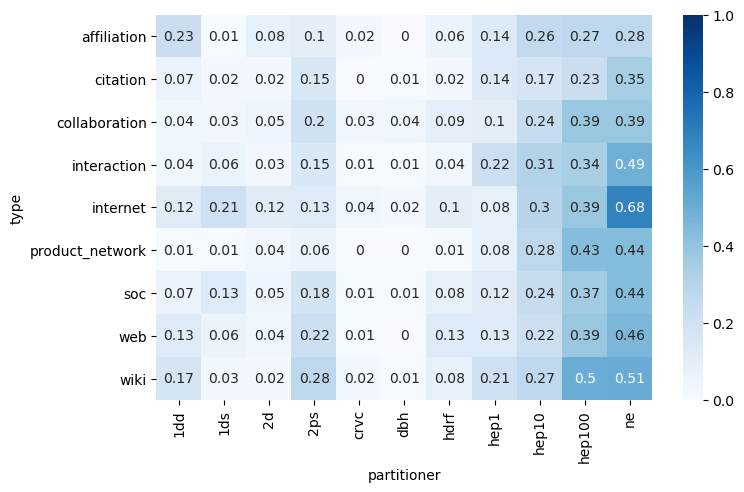

Enrichment 0.2


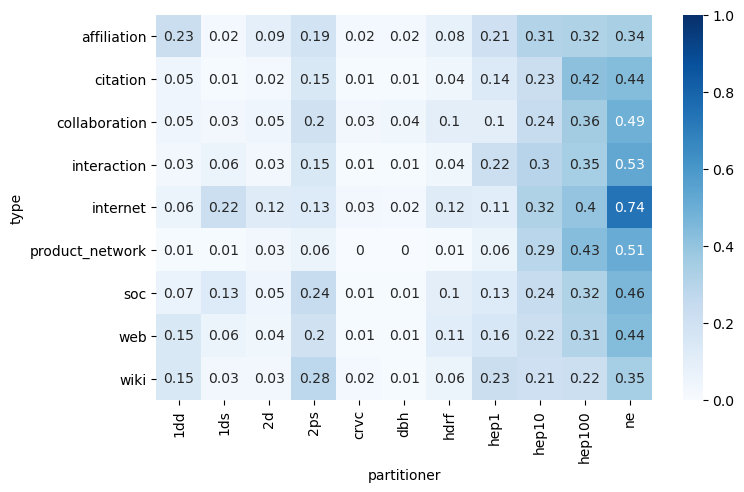

Enrichment 0.4


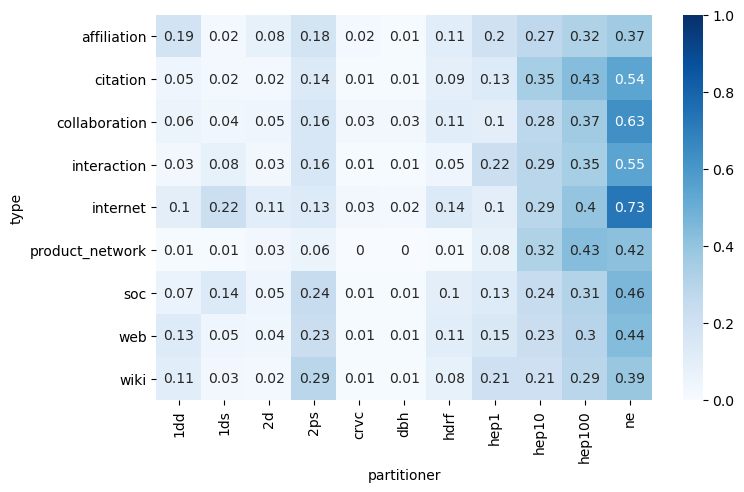

Enrichment 0.6


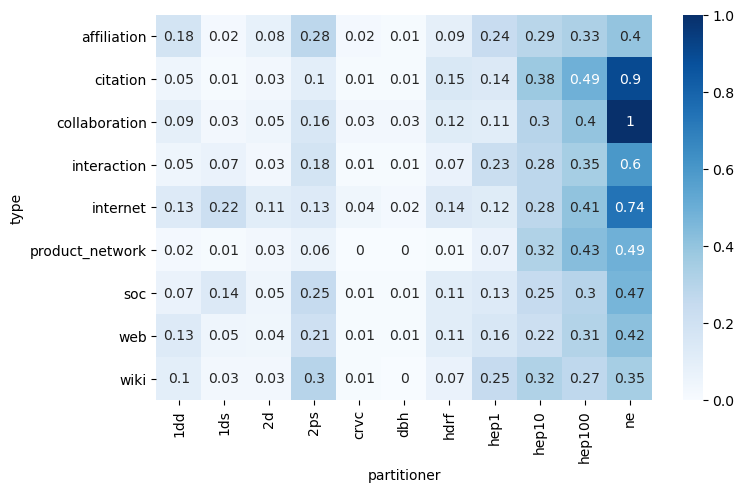

Enrichment 0.8


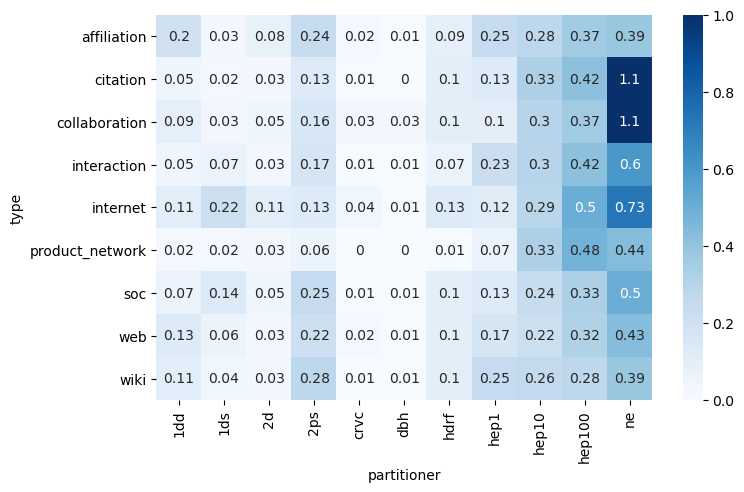

Enrichment 1.0


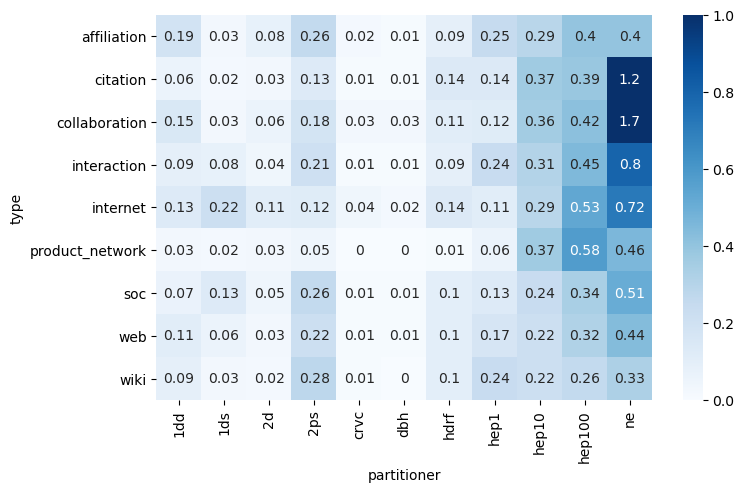

#### RFR_Easy-test_replication_factor #### RFR 
Enrichment 0.0


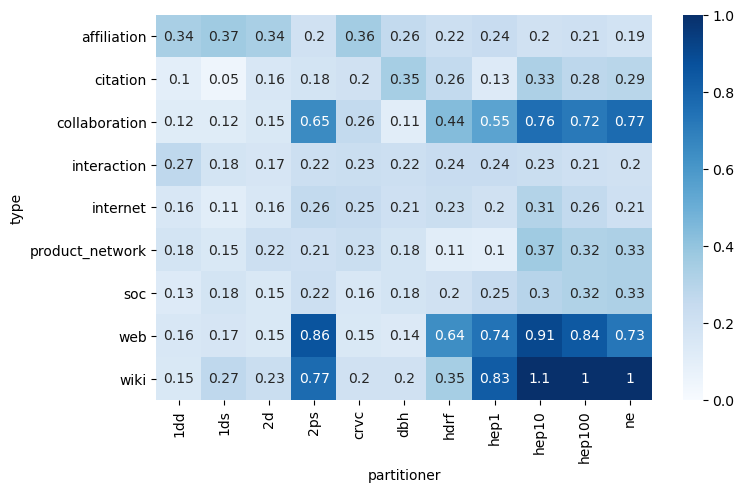

Enrichment 0.2


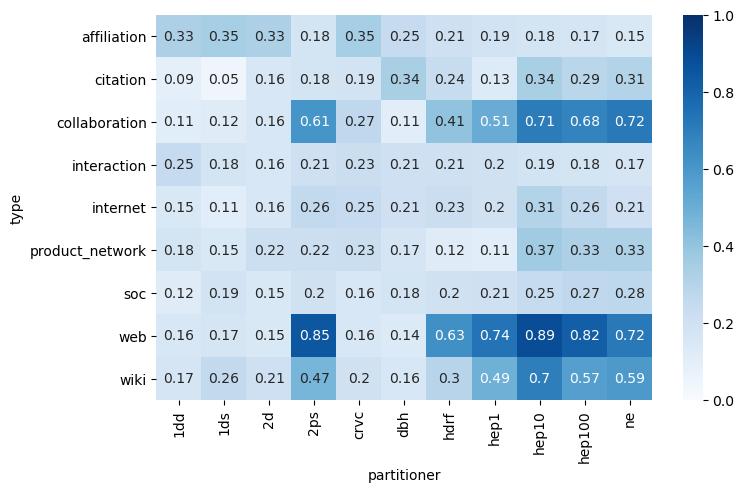

Enrichment 0.4


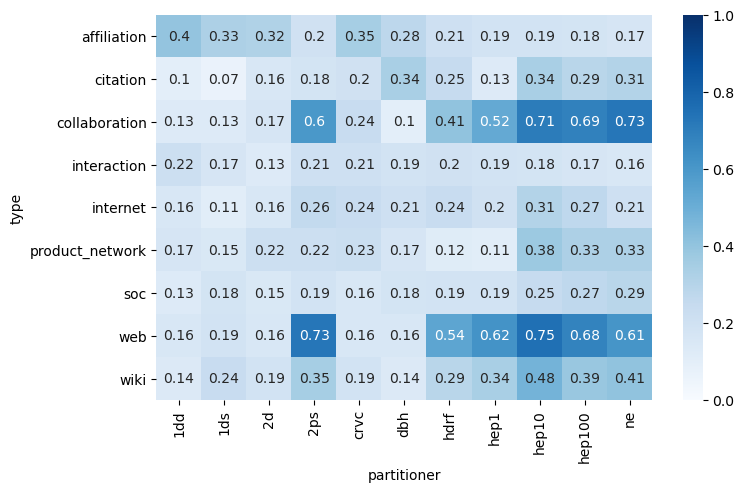

Enrichment 0.6


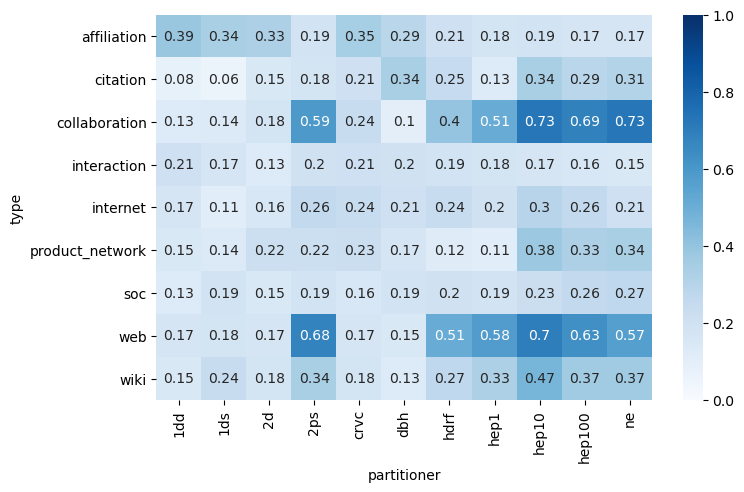

Enrichment 0.8


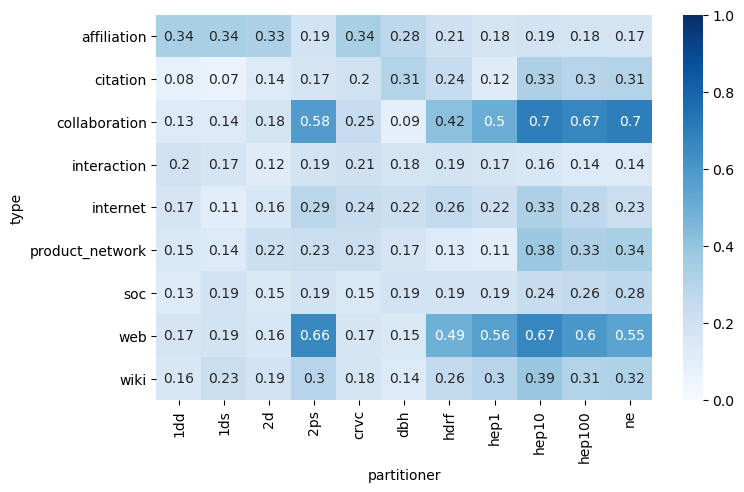

Enrichment 1.0


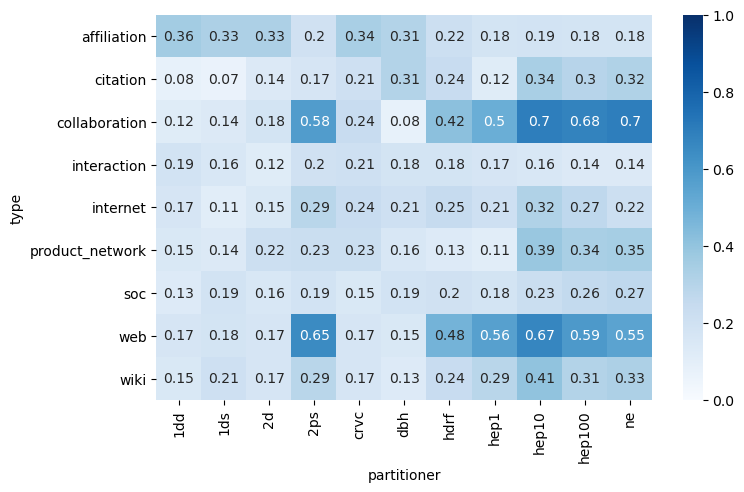

#### RFR_Easy-test_destination_balance #### RFR 
Enrichment 0.0


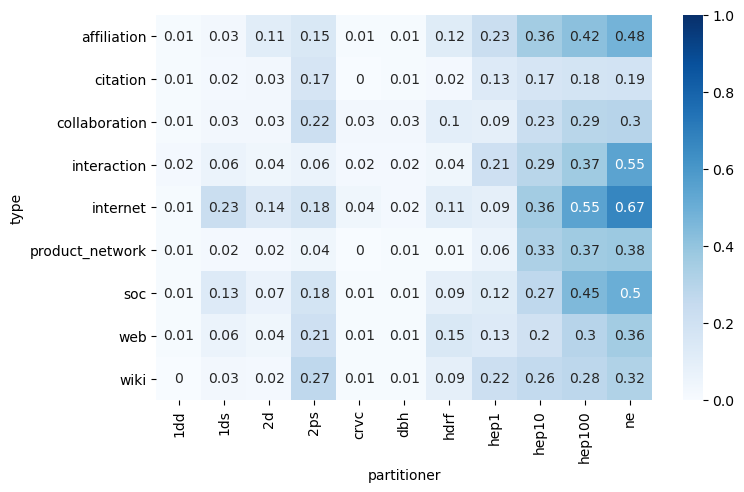

Enrichment 0.2


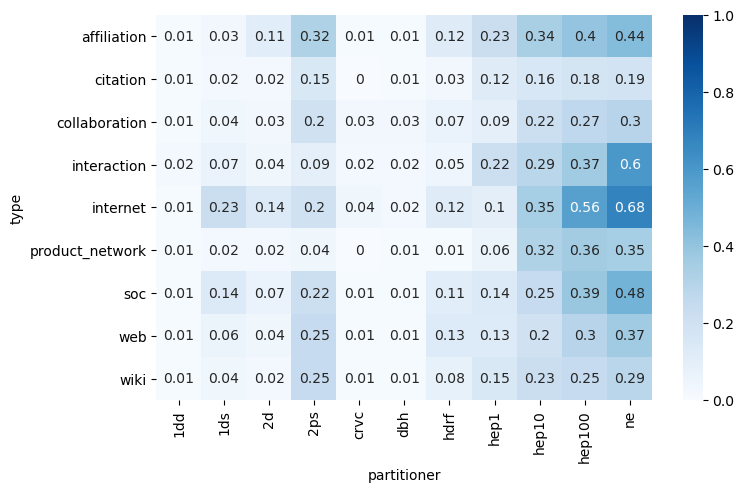

Enrichment 0.4


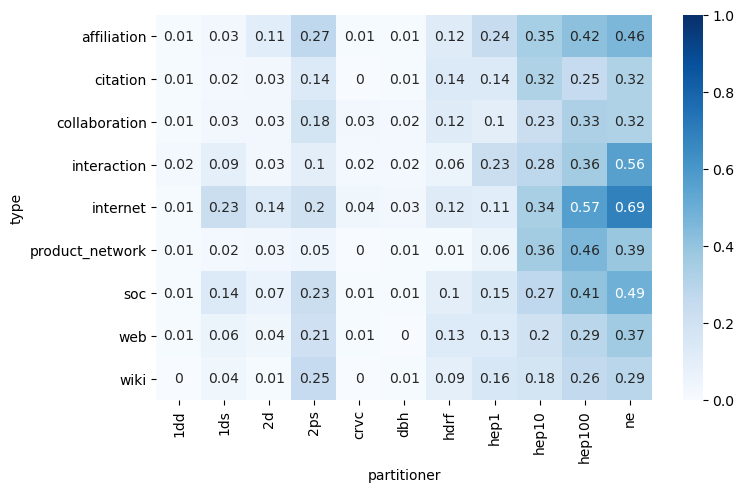

Enrichment 0.6


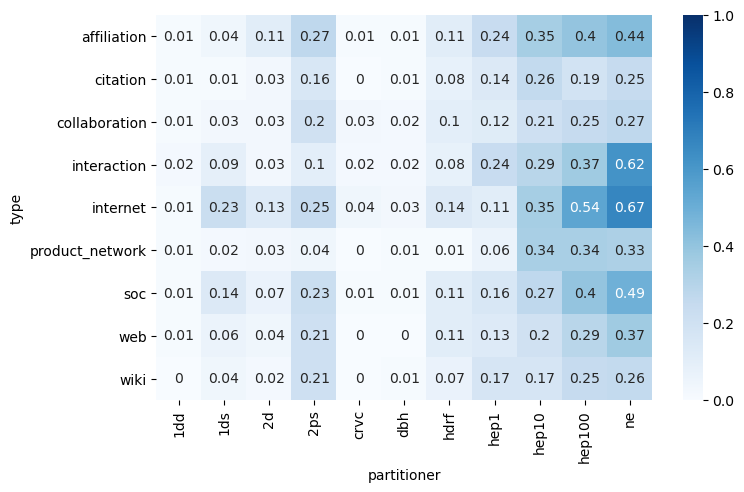

Enrichment 0.8


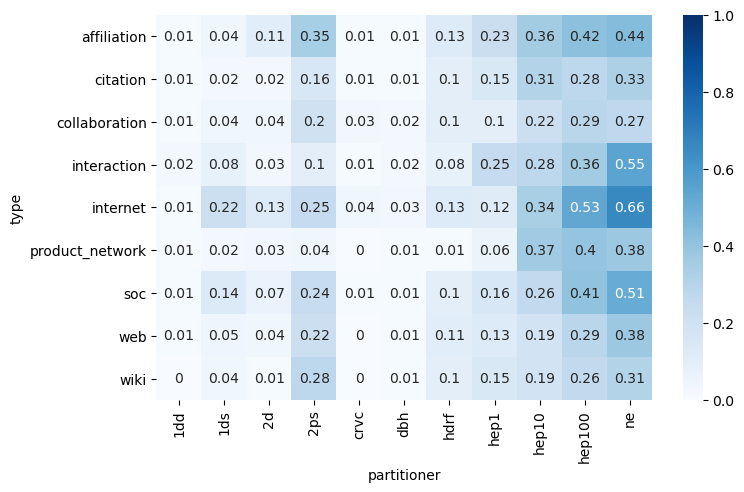

Enrichment 1.0


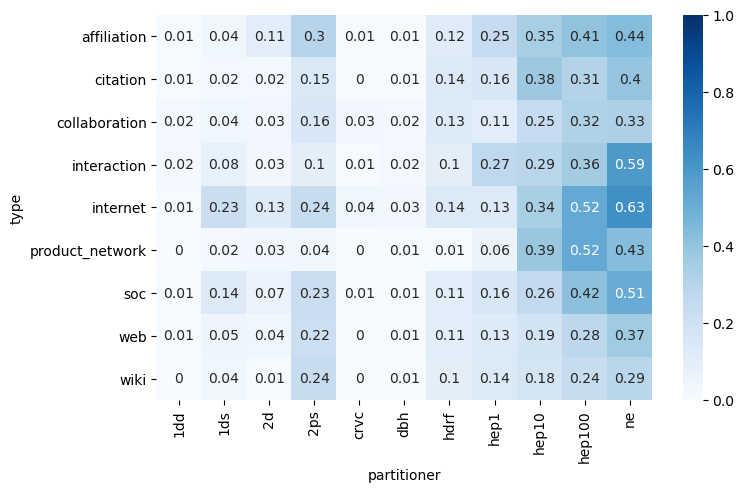

#### RFR_Easy-test_source_balance #### RFR 
Enrichment 0.0


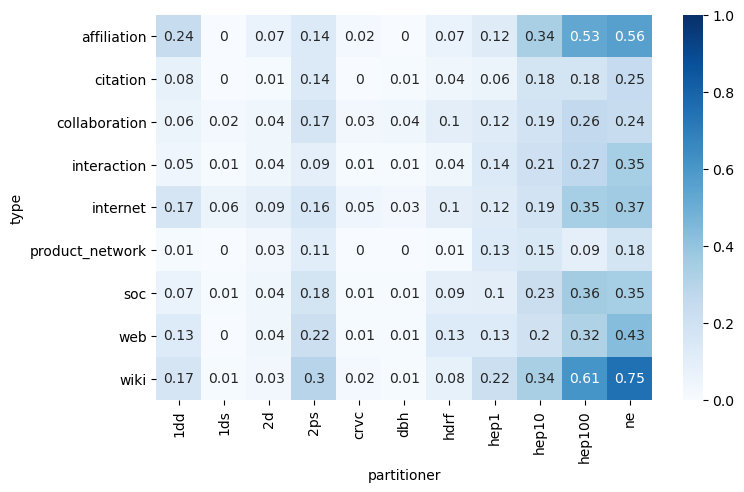

Enrichment 0.2


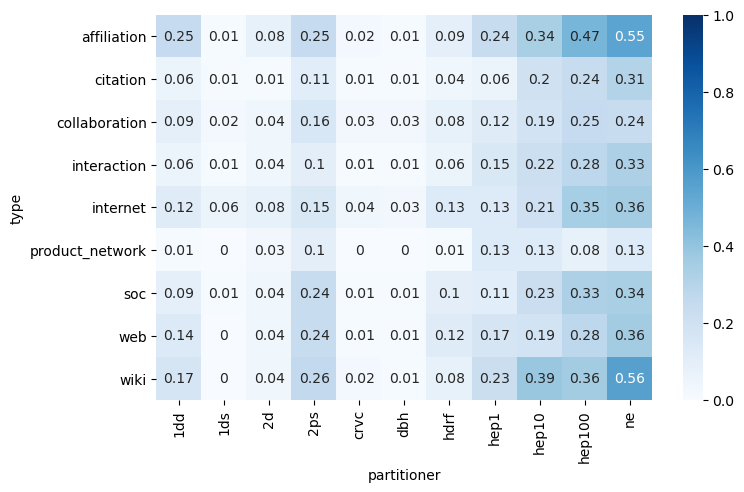

Enrichment 0.4


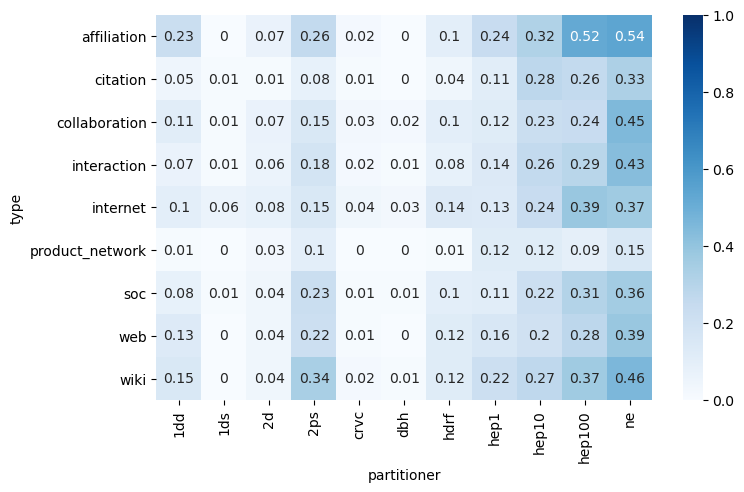

Enrichment 0.6


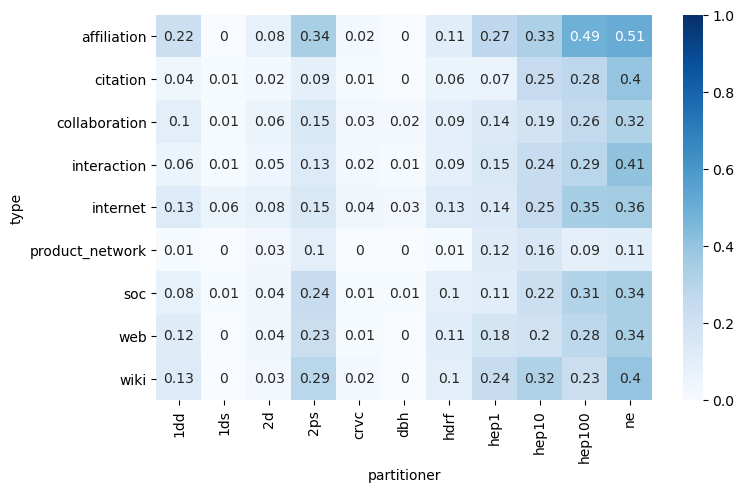

Enrichment 0.8


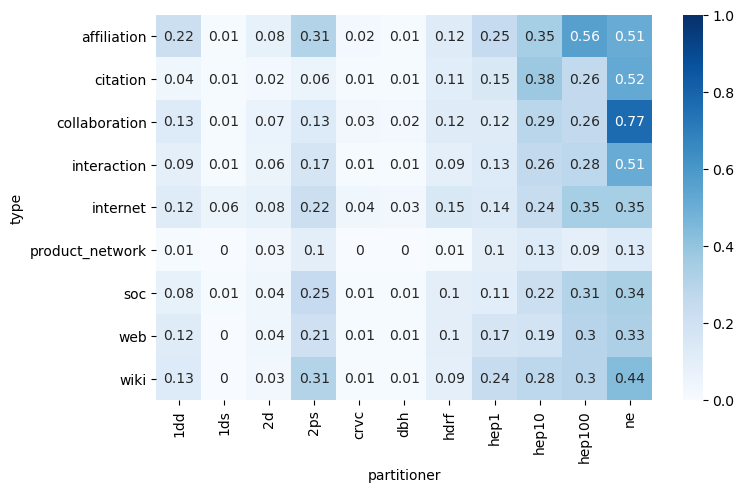

Enrichment 1.0


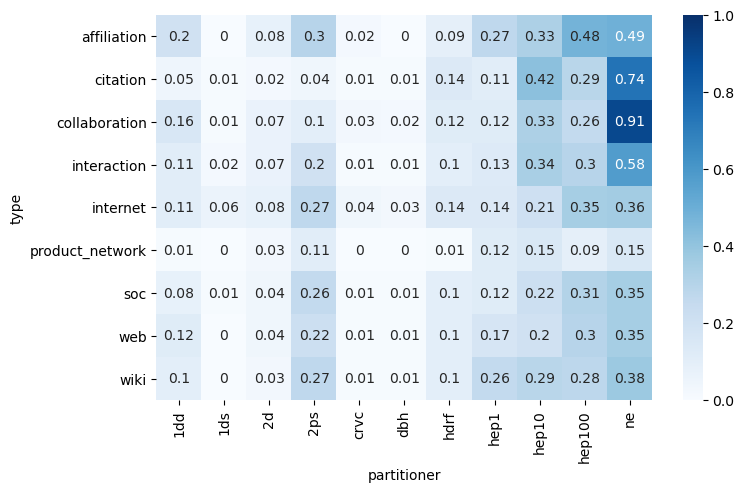

#### RFR_Easy-test_edge_balance #### RFR 
Enrichment 0.0


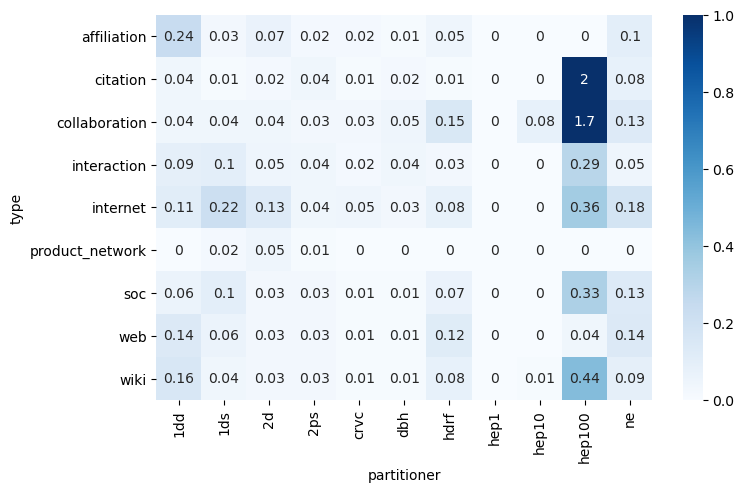

Enrichment 0.2


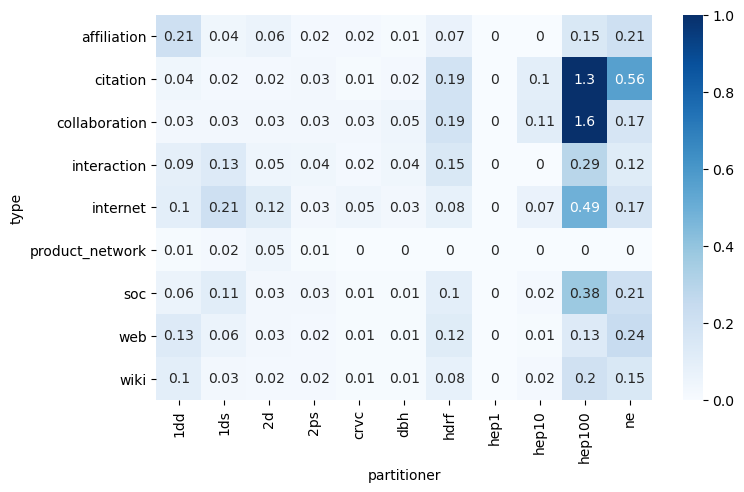

Enrichment 0.4


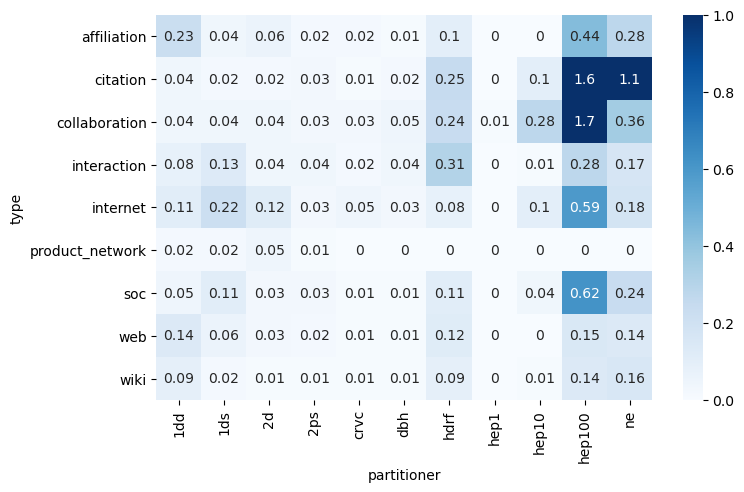

Enrichment 0.6


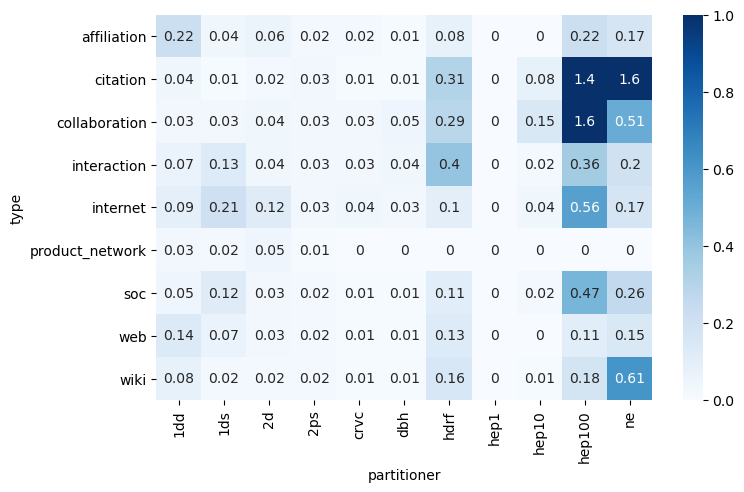

Enrichment 0.8


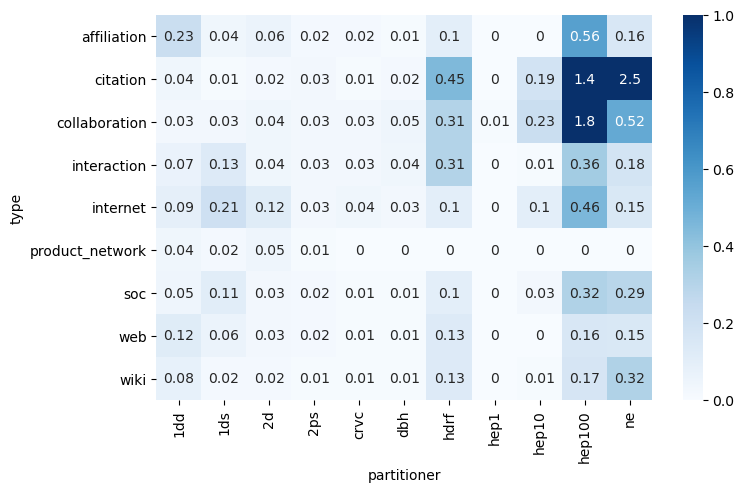

Enrichment 1.0


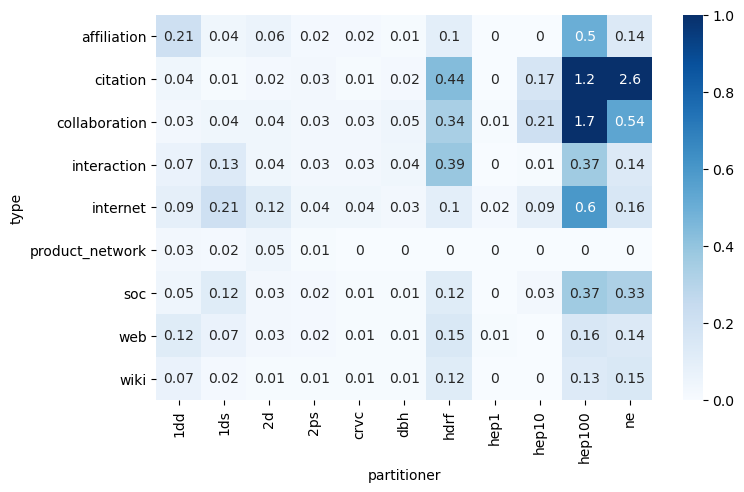

In [15]:
plt.rcParams["figure.figsize"] = (8, 5)

models =  [
    "RFR", 
    ]


for model in models:


    result_dict = {}
    targets = [
        "vertex_balance", 
        "replication_factor",
        "destination_balance", 
        "source_balance", 
        "edge_balance", 
        
    ]

    feature_sets = [
        "Easy", 
    ]
    test_sets = [
        "test"
    ]

    for target in targets:
        for feature_set in feature_sets:
            for test_set in test_sets:
                key = "{}_{}-{}_{}".format(model, feature_set, test_set, target)
                data = pd.read_csv("../models/" + key)
                print("#### {} #### {} ".format(key, model))
                plot.plot_scores_by_type_and_partitioner(data, key)